## Notebook #3 - Automating Prunning (or "what about all those hyperparameters")
In the previous tutorials we saw how to train a model and then prune it to our delight. Recall that we set target sparsity levels. Up to fairly high levels of sparsity (e.g 85% for the previous example) we got by by setting the same sparsity level throughout the model. Let's now take a closer look and build the tools needed to sparsify the network even further.

Generally speaking this is not an easy task, as sparsifying a layer too much may have detremental - unrecoverable - effects on total accuracy (consider the limiting case where a single hidden layer is completely zeroed out; trivially, all information is lost irrespective of the level of sparsity of all other layers). In other words, when one approaches the 'limit' of optimal sparsity per layer, there is strong coupling between the layers.

Finding this optimum is in principle a problem of searching over a combinatorically large space - in our example for resnet-50 with e.g. 10 sparsity levels considered per layer, the size of the space is $50^{10} \approx 10^{17}$.

Have heart - we can get very far in practice with a greedy algorithm instead. For that let us first observe that 'far enough' form the optimal sparsity configuration, layer sparsity can be well approximated as independent. 
So, as a first step, let us find the sparsity level per layer, such that holding all others layers constant, affects total accuracy. This is a per-layer sensitivity analysis.

In [1]:
## Load Data
from neuralmagicML.datasets import *
from torch.utils.data import Dataset, DataLoader
from neuralmagicML.sparsity.kernel import *

dataset_type = 'imagenette'
dataset_path = '../data/imagenette-160/'
device = 'cuda:1'
 #device to run on: 'cpu' / 'cuda:0'
    
train_batch_size = 128
test_batch_size = 256
earlystop = -1 

train_dataset = ImagenetteDataset(dataset_path, train=True, rand_trans=True)
train_data_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=8)

val_dataset = ImagenetteDataset(dataset_path, train=False, rand_trans=False)
val_data_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=True, num_workers=8)

train_test_dataset = ImagenetteDataset(dataset_path, train=True, rand_trans=False)
train_test_data_loader = DataLoader(train_test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=8)

## Load Model

from neuralmagicML.models import *
from neuralmagicML.sparsity import *
from torch.nn import Conv2d

model_path = '../neuralmagicML/checkpoints/ResNet-2019.08.07.17.54.20-89.60006713867188.pth'
print('initializing model...')
model_type = 'resnet50'
model = resnet50(num_classes = 10)
model = model.to(device)

print('loading model...')
load_model(model_path, model)
print('done')

## sparsity monitoring:

from typing import List
from tensorboardX import SummaryWriter


print('Setting up model for kernel sparsity tracking...')
conv_layers_names = []
layer_masks = {}
for name, mod in model.named_modules():
    if isinstance(mod, Conv2d): #to add the FC layers: isinstance(mod, Conv2d) or isinstance(mod, Linear) 
        conv_layers_names.append(name)
        ## explicitly add masks:
        layer_masks[name] = KSLayerMask(mod, 'weight')
        layer_masks[name].enable()
        
analyzed_layers = KSAnalyzerLayer.analyze_layers(model, conv_layers_names)

def _record_kernel_sparsity(analyzed_layers: List[KSAnalyzerLayer], writer: SummaryWriter, epoch: int):
#     layers_sparsities = []
    for ks_layer in analyzed_layers:
        tag = 'Kernel Sparsity/{}'.format(ks_layer.name)
        writer.add_scalar(tag, ks_layer.param_sparsity.item(), epoch)
    print('sparsity per layer [%]: '+ str([round(ks_layer.param_sparsity.item()*100.0,0) for ks_layer in analyzed_layers]))

## optimizer etc
import torch
from torch import optim
from torch.nn import DataParallel
from neuralmagicML.utils import CrossEntropyLossCalc, TopKAccuracy
import os

init_lr = 0.01
momentum = 0.9
weight_decay = 1e-4

print('Creating optimizer with initial lr: {}, momentum: {}, weight_decay: {}'
          .format(init_lr, momentum, weight_decay))
optimizer = optim.SGD(
    model.parameters(), init_lr, momentum=momentum, weight_decay=weight_decay, nesterov=True
)
loss_extras = {
    'top1acc': TopKAccuracy(1),
    'top5acc': TopKAccuracy(5)
}
loss_calc = CrossEntropyLossCalc(loss_extras)
print('Created loss calc {} with extras {}'.format(loss_calc, ', '.join(loss_extras.keys())))


logs_dir = './logs'
output_dir = '../pruned'
counter = 0
model_dir = None
while model_dir is None or os.path.exists(model_dir):
    model_name = '{}-{}'.format(model_type, counter)
    model_dir = os.path.join(output_dir, model_name)
    counter += 1

logs_dir = model_dir + '-logs'

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

if not os.path.exists(logs_dir):
    os.makedirs(logs_dir)
    
save_rate = 5

print('Creating summary writer in {}'.format(logs_dir))
writer = SummaryWriter(logdir=logs_dir, comment='imagenette training')
if isinstance(model, DataParallel):
    model = model.module


already downloaded imagenette of size ImagenetteSize.s160
already downloaded imagenette of size ImagenetteSize.s160
already downloaded imagenette of size ImagenetteSize.s160
initializing model...
loading model...
done
Setting up model for kernel sparsity tracking...
Creating optimizer with initial lr: 0.01, momentum: 0.9, weight_decay: 0.0001
Created loss calc <neuralmagicML.utils.loss_calc.CrossEntropyLossCalc object at 0x7f3d16a54e80> with extras top1acc, top5acc
Creating summary writer in ../pruned/resnet50-9-logs


## testing functions as ususal

In [2]:
from tqdm import tqdm
from torch.utils.data import DataLoader

from typing import Tuple, Dict
from torch import Tensor
import torch
from torch.nn import Module


def _test_datasets(model, train_data_loader: DataLoader, val_data_loader: DataLoader,
                   writer: SummaryWriter, epoch: int, earlystop: int=-1) -> Tuple[Dict[str, float], Dict[str, float]]:
    val_losses , train_losses = None, None
    if val_data_loader  is not None:
#         print('Running test for validation dataset for epoch {}'.format(epoch))
        val = test_epoch(model, val_data_loader, loss_calc, device, epoch, earlystop)
#         print('Completed test for validation dataset for epoch {}'.format(epoch))
        val_losses = {}
        for loss, _ in val.items():
            val_losses[loss] = torch.mean(torch.cat(val[loss])).item()
            val_tag = 'Test/validation/{}'.format(loss)
            writer.add_scalar(val_tag, val_losses[loss], epoch)
        
        val_loss_str = 'validation set - epoch: {} '.format(epoch)
        for loss, value in val_losses.items():
            val_loss_str += (loss + ': {0:.2f} '.format(value))
#         print(val_loss_str)
        
        
    if train_data_loader is not None:
#         print('Running test for train dataset for epoch {}'.format(epoch))
        train = test_epoch(model, train_data_loader, loss_calc, device, epoch, earlystop)
#         print('Completed test for train dataset for epoch {}'.format(epoch))
        train_losses = {}

        for loss, _ in train.items():
            train_losses[loss] = torch.mean(torch.cat(train[loss])).item()
            train_tag = 'Test/training/{}'.format(loss)
            writer.add_scalar(train_tag, train_losses[loss], epoch)

        
        train_loss_str = 'training set - epoch: {} '.format(epoch)
        for loss, value in train_losses.items():
            train_loss_str += (loss + ': {0:.2f} '.format(value))
#         print(train_loss_str)


    return val_losses , train_losses


def test_epoch(model: Module, data_loader: DataLoader, loss, device, epoch: int, earlystop: int) -> Dict:
    model.eval()
    results = {}#ModuleTestResults()
    with torch.no_grad():
        for batch, (*x_feature, y_lab) in enumerate(data_loader):
            y_lab = y_lab.to(device)
            x_feature = tuple([dat.to(device) for dat in x_feature])
            batch_size = y_lab.shape[0]
            
            y_pred = model(*x_feature)

            losses = loss(x_feature, y_lab, y_pred)  # type: Dict[str, Tensor]
            for key, val in losses.items():
                if key not in results:
                    results[key] = []

                result = val.detach_().cpu()
                result = result.repeat(batch_size) #repeat tensor so that there is no dependency on batch size
                results[key].append(result)
            
            if earlystop>0.0:
                if batch_size*batch > earlystop:
#                 print('stopped after {} samples'.format(batch_size*batch))
                    break
#             results.append(losses, batch_size)
    return results

def train_epoch(model: Module, data_loader: DataLoader, optimizer, loss, device, data_counter: int):
    model.train()
    
    for batch, (*x_feature, y_lab) in enumerate(tqdm(data_loader)):
        # copy next batch to the device we are using
        y_lab = y_lab.to(device)
        x_feature = tuple([dat.to(device) for dat in x_feature])
        batch_size = y_lab.shape[0]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward 
        y_pred = model(*x_feature)
        
        # update losses
        losses = loss(x_feature, y_lab, y_pred)  # type: Dict[str, Tensor]
        
        # backward
        losses['loss'].backward()
        
        # take SGD step
        optimizer.step(closure=None)
        
        # log loss and accuracy
        data_counter += batch_size
        for _loss, _value in losses.items():
            writer.add_scalar('Train/{}'.format(_loss), _value.item(), data_counter)

    return data_counter




## Sensitivity analysis

In [ ]:
start = 0.3
end = 0.99
steps = 15
gamma = ((1-end)/(1-start))**(1/(steps-1))
sparsities = [1-(1-start)*gamma**ii for ii in range(steps)] #geometric steps
# sparsities = [start+ ii*(end - start)/(steps-1) for ii in range(steps)]            
print(sparsities)

In [ ]:
from tqdm import tqdm


layer_sparsity_dict = {}
exp_idx=0
 # nember of samples to evaluate acc on 1000 per class for imagenette
for lidx, ks_layer in enumerate(tqdm(analyzed_layers)):
    layer_mask = layer_masks[ks_layer.name]
    orig_mask = layer_mask.mask_tensor.clone()
    val_losses, train_losses = _test_datasets(model, None, val_data_loader, writer, exp_idx, earlystop )
    exp_idx +=1
    baseline_val_acc = val_losses['top1acc']
#     baseline_train_acc = train_losses['top1acc']


    if ks_layer.name not in layer_sparsity_dict.keys():
        layer_sparsity_dict[ks_layer.name]=[[ks_layer.param_sparsity.item(), baseline_val_acc]] #, baseline_train_acc
#     print('performing sensitivity anlysis for layer {}'.format(ks_layer.name))


    for sidx, sparsity in enumerate(sparsities):
#         print('sparsity {}'.format(sparsity))

        layer_mask.apply_mask_tensor(mask_from_sparsity(layer_mask.init_param_tensor, sparsity))
#         global_sparsity = get_global_sparsity(layer_masks)  # calculate total_sparsity
        
        val_losses, train_losses = _test_datasets(model, None, val_data_loader, writer, exp_idx, earlystop)
        exp_idx +=1
        masked_val_acc = val_losses['top1acc']
#         masked_train_acc = train_losses['top1acc']
        layer_sparsity_dict[ks_layer.name].append([ks_layer.param_sparsity.item(), masked_val_acc]) #, masked_train_acc
#         if masked_val_acc < 0.5*baseline_val_acc:
#             break
            
    layer_mask.apply_mask_tensor(orig_mask) #revert to original mask
    layer_mask.apply_new_tensor(layer_mask.init_param_tensor) #revert to original param


In [ ]:
from neuralmagicML.sparsity.utils import tensor_sparsity
for lidx, ks_layer in enumerate(tqdm(analyzed_layers)):
    layer_mask = layer_masks[ks_layer.name]
    print(tensor_sparsity(layer_mask.param_tensor))

In [3]:
import pickle
# filename = 'sens_90p_pruned'
# with open(filename,'wb') as outfile:
#     pickle.dump(layer_sparsity_dict,outfile)
#     outfile.close()

filename = 'sens'
with open(filename,'rb') as infile:
    layer_sparsity_dict = pickle.load(infile)

## what did we get?
By reviewing the dependency of the accuracy on the sparsity level of each layer (independently) it is evident that there are layers which affect accuracy more than others - we call these layers with high sensitivity.

The blow cell visualizes the error (1 - accuracy) versus density (1 - sparsity):



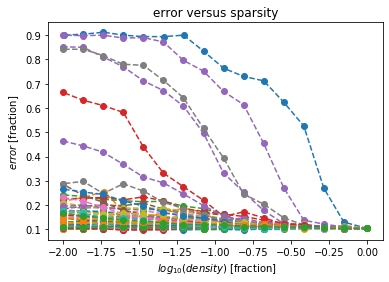

In [5]:

import matplotlib.pyplot as plt
import numpy as np

for layer_name, res_list in layer_sparsity_dict.items():
    sparsities = [res_list[ii][0] for ii in range(len(res_list))]
    densities = [1- spar for spar in sparsities]
    val_accs = [res_list[ii][1] for ii in range(len(res_list))]
#     train_accs = [val_accs[0]]
#     train_accs.extend([res_list[ii+1][2] for ii in range(len(res_list)-1)])
    val_err = [1-(acc/100) for acc in val_accs]
#     train_err = [1-(acc/100) for acc in train_accs]
#     plt.plot(densities, val_err, label=layer_name, linestyle='', marker='o')
    plt.plot(np.log10(densities), val_err, label=layer_name, linestyle='--', marker='o')
plt.title('error versus sparsity')
plt.ylabel('$error$ [fraction]')
plt.xlabel(' $log_{10}(density)$ [fraction]')
# plt.legend(loc='right')
plt.show()


## How we use this information?
With the gleaned insight into the sensitivity (to prunning) of each layer, let us guide the sparsity allocation such that less sensitive layers are targeted with correspondingly higher sparsity levels.

First let us define a metric for quantifying this sensitivity. With no particular attachment, let us examine the criterion defined by the sparsity level at a relative error increase of x%

Let x for example be 5%, such that we evaluate for each layer what was the sparsity at which the error changed by (1 - baseline_acc)*(1+x).
Note that this error is going to be removed by retraining.

Text(0.5, 1.0, 'sparsity level at 5.0% relative acc loss per layer')

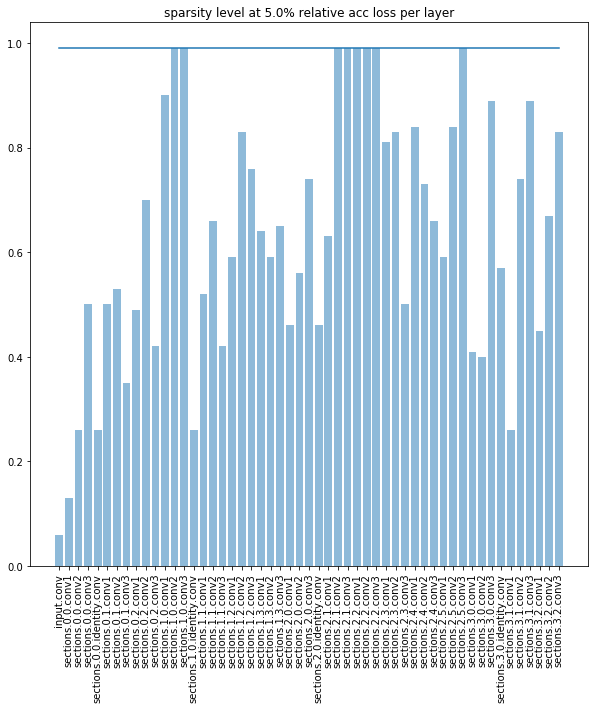

In [6]:
from scipy.interpolate import interp1d
thresh_sparsity = {}
max_sparsity = 0.99
acc_hit_rel = 0.05
for layer_name, res_list in layer_sparsity_dict.items():
    sparsities = [res_list[ii][0] for ii in range(len(res_list))]
    densities = [1- spar for spar in sparsities]
    accs = [res_list[ii][1] for ii in range(len(res_list))]
    err = [1-(acc/100) for acc in accs]
    f=interp1d(densities,err,'linear')
    eval_dens = np.arange(min(densities),max(densities),0.01)
    if err[np.argmax(sparsities)]/err[np.argmin(sparsities)] > 1+acc_hit_rel:
        thresh = np.argmin(np.abs(f(eval_dens)-(1+acc_hit_rel)*err[np.argmin(sparsities)]))
        thresh_sparsity[layer_name] = 1-eval_dens[thresh]
    else:
        thresh_sparsity[layer_name] = min(max_sparsity, max(sparsities))
    

y_pos= [ii for ii in range(len(thresh_sparsity.values()))]
spars= [r for r in thresh_sparsity.values()]

names = [k for k in thresh_sparsity.keys()]
plt.figure(figsize=(10,10))
# plt.plot(y_pos,ratios, marker='o',linestyle = 'None')
plt.bar(y_pos, spars, align='center', alpha=0.5)
plt.xticks(y_pos, names,rotation='vertical')
plt.plot(y_pos, [max_sparsity for _ in range(len(y_pos))])
plt.title('sparsity level at {}% relative acc loss per layer'.format(acc_hit_rel*100))


In [7]:
layers_param_count={}
for ks_layer in analyzed_layers:
    layer_mask = layer_masks[ks_layer.name].mask_tensor
    layers_param_count[ks_layer.name] = layer_mask.numel()

dens_list=[]
n_param_list=[]
dense_x_param=[]
for layer_name, n_param in layers_param_count.items():
    dens_i = 1-thresh_sparsity[layer_name]
    dens_list.append(dens_i)
    n_param_list.append(n_param)
    dense_x_param.append(dens_i*n_param)

beta = np.sum(n_param_list)/np.sum(dense_x_param)

print('total sparsity: {}'.format(1-np.sum(dense_x_param)/np.sum(n_param_list)))
# original_sparsities = 1- np.array(dens_list)
# print('original sparsities: {}'.format(original_sparsities))
# target_sparsity = 0.95
# target_sparsities = 1 - target_densities
# print('target sparsities: {}'.format(target_sparsities))

total sparsity: 0.6641975339033139


In [8]:
import ipywidgets as widgets

############################################################
## configuration of sparsity levels / enables per layer ####
############################################################
c0 = widgets.VBox([widgets.Checkbox(description=ks_layer.name, value=True) for ks_layer in analyzed_layers])
c1 = widgets.VBox([widgets.FloatRangeSlider(value=[0.3, 0.8],
                                            min=0.0,max=0.99,step=0.01) for _ in range(len(analyzed_layers))])

layer_ctrl = widgets.HBox([c0,c1])
global_ctrl = widgets.HBox([widgets.Checkbox(description='normalize', value = True), 
                            widgets.FloatRangeSlider(value=[0.3, 0.8],min=0.0,max=0.99,step=0.01,description='sparsity [%]')
                           ])
output2 = widgets.Output()

activated_layers = [child.value for child in layer_ctrl.children[0].children]

def global_enable_change(change):
    with output2:
        state = change['new']
        print(state)
        if state is not None:
            for ckbx_child in layer_ctrl.children[0].children:
                ckbx_child.value = state
                
global_ctrl.children[0].observe(global_enable_change, names='value')   

def global_sparsity_set(change):
    with output2:
        val = change['new']
        if val is not None:
            for ckbx_child, sldr_child in zip(layer_ctrl.children[0].children, layer_ctrl.children[1].children):
                layer_name = ckbx_child.description
                if not global_ctrl.children[0].value:
                    sldr_child.value = val
                else:
                    sldr_child.value = [val[0],
                                        1- beta*(1-val[1])*(1-thresh_sparsity[layer_name])]
                    
    
global_ctrl.children[1].observe(global_sparsity_set, names='value')   

###############################################
## configuration of learning rate schedule ####
###############################################

lr_class_dict = {   #TODO: read from CONSTRUCTORS in modifier_lr.py instead
                    #to include all supported methods in the GUI
    'ExponentialLR': {'gamma': [0.95, widgets.BoundedFloatText]}, #bound by 0.0
    'StepLR': {'step_size': [20, widgets.BoundedIntText], #bound by 1
              'gamma': [0.2, widgets.BoundedFloatText]}
}

lr_mod_args_field_initval = {
    'start_epoch': 25.0,# 'start epoch:'],
    'end_epoch': 40.0,# 'end epoch  :'],
    'update_frequency': 1.0,# 'update freq:'],
    'init_lr': 0.01# 'initial learning rate :']
}

style = {'description_width': 'initial'}
# lr_cfg_list = [widgets.Text(value='learning rate schedule', disabled=True)]
lr_section_title = widgets.Text(value='learning rate schedule', disabled=True)
lr_cfg_list =[]
for fld, val in lr_mod_args_field_initval.items():
    lr_cfg_list.append(widgets.BoundedFloatText(value=val, description=fld, disabled=False, min=0, style=style,))

lr_slct = widgets.Dropdown(
    options=[key for key in lr_class_dict.keys()],  
    value=[key for key in lr_class_dict.keys()][0],
    description='lr_class',
)
# lr_cfg_list.append(lr_slct)

def create_lr_slct_list():
    lr_slct_params = [] #create new widgets
    for param, val in lr_class_dict[lr_slct.value].items():
        lr_slct_params.append(val[1](value=val[0],description=param))
    return lr_slct_params
slct_param = widgets.VBox(children=create_lr_slct_list())
# lr_cfg_list.append(slct_param)

def refresh_lr_param(change):
    if change['new']:
        val = lr_slct.value
        slct_param.children = create_lr_slct_list()

lr_slct.observe(refresh_lr_param, names='value')   
lr_cfg = widgets.VBox([lr_section_title, *lr_cfg_list, lr_slct, slct_param])

##########################################
## configuration of prunning schedule ####
##########################################

prunning_mod_args_field_initval = {
    'start_epoch': 0.0,# 'start epoch:'],
    'end_epoch': 25.0,#'end epoch  :'],
    'update_frequency': 1.0#,'update freq:'],
}


style = {'description_width': 'initial'}
prn_section_title = widgets.Text(value='prunning schedule', disabled=True)
prn_cfg_list =[]
for fld, val in prunning_mod_args_field_initval.items():
    prn_cfg_list.append(widgets.BoundedFloatText(value=val, description=fld, disabled=False, min=0, style=style,))

prn_slct = widgets.Dropdown(
    options=['linear', 'cubic', 'inverse_cubic', 'geometric'],  
    value='cubic',
    description='inter_func',
)

prn_cfg = widgets.VBox([prn_section_title,*prn_cfg_list,prn_slct])
schd_cfg = widgets.VBox([lr_cfg, prn_cfg])#,prn_cfg_list])
display(widgets.HBox([widgets.VBox([global_ctrl,layer_ctrl]),schd_cfg]))



In [9]:
print('Creating learning rate schedule...')
lr_mod_args = {}

for child in lr_cfg_list: 
    lr_mod_args[child.description] = child.value
assert(lr_slct.description == 'lr_class')
lr_mod_args['lr_class'] = lr_slct.value
lr_mod_args['lr_kwargs'] = {}
for child in slct_param.children:
    lr_mod_args['lr_kwargs'][child.description] = child.value

lr_mod = LearningRateModifier(**lr_mod_args)

print('Creating sparsification schedule...')

def create_ks_mod_args(layer_name, init_sparsity, final_sparsity):
    ks_mod_args ={
        'param': 'weight',
        'init_sparsity': init_sparsity,
        'layers': [layer_name],
        'final_sparsity': final_sparsity,
        'inter_func': prn_slct.value
    }
    # add common fields
    for child in prn_cfg_list:
        ks_mod_args[child.description] = child.value
    return ks_mod_args

ks_mod_args_list = []
for ckbx_child, sldr_child in zip(layer_ctrl.children[0].children, layer_ctrl.children[1].children):
        if ckbx_child.value: #layer is sparsified
            layer_name = ckbx_child.description
            init_sparsity, final_sparsity = sldr_child.value[0], sldr_child.value[1]#
            ks_mod_args_list.append(create_ks_mod_args(layer_name,init_sparsity, final_sparsity))
            
ks_mod_list = [GradualKSModifier(**ks_mod_args) for ks_mod_args in ks_mod_args_list]
modifiers = [lr_mod, *ks_mod_list]

modifier_manager = ScheduledModifierManager(modifiers)
optimizer = ScheduledOptimizer(optimizer, model, modifier_manager, steps_per_epoch=len(train_dataset))

Creating learning rate schedule...
Creating sparsification schedule...


In [10]:
ks_mod_args_list

[{'param': 'weight',
  'init_sparsity': 0.05,
  'layers': ['input.conv'],
  'final_sparsity': 0.7200444021114916,
  'inter_func': 'cubic',
  'start_epoch': 0.0,
  'end_epoch': 25.0,
  'update_frequency': 1.0},
 {'param': 'weight',
  'init_sparsity': 0.05,
  'layers': ['sections.0.0.conv1'],
  'final_sparsity': 0.7409162071565901,
  'inter_func': 'cubic',
  'start_epoch': 0.0,
  'end_epoch': 25.0,
  'update_frequency': 1.0},
 {'param': 'weight',
  'init_sparsity': 0.05,
  'layers': ['sections.0.0.conv2'],
  'final_sparsity': 0.7796294428010746,
  'inter_func': 'cubic',
  'start_epoch': 0.0,
  'end_epoch': 25.0,
  'update_frequency': 1.0},
 {'param': 'weight',
  'init_sparsity': 0.05,
  'layers': ['sections.0.0.conv3'],
  'final_sparsity': 0.8511000316831996,
  'inter_func': 'cubic',
  'start_epoch': 0.0,
  'end_epoch': 25.0,
  'update_frequency': 1.0},
 {'param': 'weight',
  'init_sparsity': 0.05,
  'layers': ['sections.0.0.identity.conv'],
  'final_sparsity': 0.7796294428010746,
  'int

In [11]:
import math
print('Running baseline test...')
epoch = -1
_record_kernel_sparsity(analyzed_layers, writer, epoch)
_test_datasets(model, None, val_data_loader, writer, epoch=-1)

print('Training model')
num_epochs = int(math.ceil(modifier_manager.max_epochs))
data_counter = 0

for epoch in range(num_epochs):
    print('Starting epoch {}'.format(epoch))
    optimizer.epoch_start()
    _record_kernel_sparsity(analyzed_layers, writer, epoch)



    data_counter = train_epoch(model, train_data_loader, optimizer, loss_calc, device, data_counter)
    optimizer.epoch_end()
    val_losses, train_losses = _test_datasets(model, None, val_data_loader, writer, epoch)

    if save_rate > 0 and epoch % save_rate == 0:
        save_path = os.path.join(model_dir, 'resnet50-epoch={:03d}-val={:.4f}.pth'
                                 .format(epoch, val_losses['loss']))
        save_model(save_path, model, optimizer, epoch)
        print('saved model checkpoint at {}'.format(save_path))

_record_kernel_sparsity(analyzed_layers, writer, num_epochs)


scalars_json_path = os.path.join(logs_dir, 'all_scalars.json')
writer.export_scalars_to_json(scalars_json_path)
writer.close()

save_path = os.path.join(model_dir, 'resnet50-pruned.pth')
print('Finished training, saving model to {}'.format(save_path))
save_model(save_path, model)
print('Saved model')

Running baseline test...
sparsity per layer [%]: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Training model
Starting epoch 0


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]


100%|██████████| 101/101 [01:07<00:00,  1.67it/s]


saved model checkpoint at ../pruned/resnet50-9/resnet50-epoch=000-val=0.4751.pth
Starting epoch 1


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [13.0, 13.0, 13.0, 14.0, 13.0, 14.0, 14.0, 14.0, 14.0, 15.0, 14.0, 16.0, 16.0, 16.0, 13.0, 14.0, 15.0, 14.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 14.0, 14.0, 15.0, 14.0, 15.0, 16.0, 16.0, 16.0, 16.0, 16.0, 15.0, 15.0, 14.0, 15.0, 15.0, 15.0, 15.0, 15.0, 16.0, 14.0, 14.0, 16.0, 14.0, 13.0, 15.0, 16.0, 14.0, 15.0, 15.0]


100%|██████████| 101/101 [01:07<00:00,  1.64it/s]


Starting epoch 2


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [20.0, 20.0, 21.0, 23.0, 21.0, 23.0, 23.0, 22.0, 23.0, 24.0, 22.0, 25.0, 26.0, 26.0, 21.0, 23.0, 24.0, 22.0, 23.0, 25.0, 24.0, 24.0, 23.0, 24.0, 22.0, 23.0, 24.0, 22.0, 24.0, 26.0, 26.0, 26.0, 26.0, 26.0, 25.0, 25.0, 23.0, 25.0, 24.0, 24.0, 23.0, 25.0, 26.0, 22.0, 22.0, 25.0, 23.0, 21.0, 24.0, 25.0, 22.0, 24.0, 25.0]


100%|██████████| 101/101 [01:02<00:00,  1.81it/s]


Starting epoch 3


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [26.0, 27.0, 28.0, 31.0, 28.0, 31.0, 31.0, 29.0, 30.0, 32.0, 30.0, 34.0, 35.0, 35.0, 28.0, 31.0, 32.0, 30.0, 31.0, 34.0, 33.0, 32.0, 31.0, 32.0, 30.0, 31.0, 33.0, 30.0, 32.0, 35.0, 35.0, 35.0, 35.0, 35.0, 33.0, 34.0, 31.0, 34.0, 33.0, 32.0, 31.0, 34.0, 35.0, 30.0, 30.0, 34.0, 31.0, 28.0, 33.0, 34.0, 30.0, 32.0, 34.0]


100%|██████████| 101/101 [01:01<00:00,  1.64it/s]


Starting epoch 4


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [32.0, 33.0, 35.0, 38.0, 35.0, 38.0, 38.0, 36.0, 38.0, 40.0, 37.0, 42.0, 43.0, 43.0, 35.0, 38.0, 40.0, 37.0, 39.0, 42.0, 41.0, 39.0, 39.0, 39.0, 37.0, 38.0, 41.0, 37.0, 39.0, 43.0, 43.0, 43.0, 43.0, 43.0, 41.0, 42.0, 38.0, 42.0, 40.0, 40.0, 39.0, 42.0, 43.0, 37.0, 36.0, 42.0, 38.0, 35.0, 41.0, 42.0, 37.0, 40.0, 42.0]


100%|██████████| 101/101 [01:07<00:00,  1.65it/s]


Starting epoch 5


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [38.0, 39.0, 41.0, 44.0, 41.0, 44.0, 45.0, 42.0, 44.0, 47.0, 43.0, 50.0, 51.0, 51.0, 41.0, 44.0, 46.0, 43.0, 45.0, 49.0, 48.0, 46.0, 45.0, 46.0, 44.0, 45.0, 48.0, 44.0, 46.0, 51.0, 51.0, 51.0, 51.0, 51.0, 49.0, 49.0, 44.0, 49.0, 47.0, 46.0, 45.0, 49.0, 51.0, 43.0, 43.0, 50.0, 45.0, 41.0, 48.0, 50.0, 43.0, 47.0, 49.0]


100%|██████████| 101/101 [01:06<00:00,  1.65it/s]


saved model checkpoint at ../pruned/resnet50-9/resnet50-epoch=005-val=0.4261.pth
Starting epoch 6


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [43.0, 44.0, 46.0, 50.0, 46.0, 50.0, 50.0, 47.0, 50.0, 53.0, 49.0, 57.0, 58.0, 58.0, 46.0, 50.0, 53.0, 49.0, 51.0, 55.0, 54.0, 52.0, 51.0, 52.0, 49.0, 51.0, 54.0, 49.0, 52.0, 58.0, 58.0, 58.0, 58.0, 58.0, 55.0, 55.0, 50.0, 56.0, 54.0, 53.0, 51.0, 56.0, 58.0, 48.0, 48.0, 56.0, 51.0, 46.0, 54.0, 56.0, 49.0, 53.0, 55.0]


100%|██████████| 101/101 [01:06<00:00,  1.63it/s]


Starting epoch 7


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [47.0, 48.0, 51.0, 55.0, 51.0, 55.0, 56.0, 52.0, 55.0, 59.0, 54.0, 63.0, 64.0, 64.0, 51.0, 56.0, 58.0, 54.0, 57.0, 61.0, 60.0, 58.0, 57.0, 58.0, 54.0, 56.0, 60.0, 54.0, 58.0, 64.0, 64.0, 64.0, 64.0, 64.0, 61.0, 61.0, 55.0, 62.0, 60.0, 58.0, 57.0, 62.0, 64.0, 54.0, 53.0, 62.0, 57.0, 51.0, 60.0, 62.0, 54.0, 58.0, 61.0]


100%|██████████| 101/101 [01:06<00:00,  1.66it/s]


Starting epoch 8


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [51.0, 52.0, 55.0, 60.0, 55.0, 60.0, 61.0, 57.0, 60.0, 64.0, 58.0, 68.0, 69.0, 69.0, 55.0, 60.0, 63.0, 58.0, 62.0, 67.0, 65.0, 63.0, 62.0, 63.0, 59.0, 61.0, 65.0, 59.0, 63.0, 69.0, 69.0, 69.0, 69.0, 69.0, 66.0, 67.0, 60.0, 67.0, 65.0, 63.0, 62.0, 67.0, 69.0, 58.0, 58.0, 68.0, 61.0, 55.0, 65.0, 68.0, 59.0, 63.0, 67.0]


100%|██████████| 101/101 [01:07<00:00,  1.64it/s]


Starting epoch 9


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [54.0, 56.0, 59.0, 64.0, 59.0, 64.0, 65.0, 61.0, 64.0, 69.0, 62.0, 73.0, 74.0, 74.0, 59.0, 65.0, 68.0, 62.0, 66.0, 71.0, 70.0, 67.0, 66.0, 67.0, 63.0, 65.0, 69.0, 63.0, 67.0, 74.0, 74.0, 74.0, 74.0, 74.0, 71.0, 71.0, 64.0, 72.0, 69.0, 68.0, 66.0, 72.0, 74.0, 62.0, 62.0, 73.0, 66.0, 59.0, 69.0, 73.0, 63.0, 68.0, 71.0]


100%|██████████| 101/101 [01:06<00:00,  1.64it/s]


Starting epoch 10


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [58.0, 59.0, 62.0, 68.0, 62.0, 68.0, 69.0, 64.0, 68.0, 72.0, 66.0, 77.0, 79.0, 79.0, 62.0, 68.0, 72.0, 66.0, 70.0, 76.0, 74.0, 71.0, 70.0, 71.0, 67.0, 69.0, 73.0, 67.0, 71.0, 79.0, 79.0, 79.0, 79.0, 79.0, 75.0, 76.0, 68.0, 76.0, 73.0, 72.0, 70.0, 76.0, 79.0, 66.0, 65.0, 77.0, 69.0, 62.0, 73.0, 77.0, 67.0, 72.0, 76.0]


100%|██████████| 101/101 [01:06<00:00,  1.60it/s]


saved model checkpoint at ../pruned/resnet50-9/resnet50-epoch=010-val=0.4397.pth
Starting epoch 11


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [60.0, 62.0, 65.0, 71.0, 65.0, 71.0, 72.0, 67.0, 71.0, 76.0, 69.0, 81.0, 82.0, 82.0, 65.0, 72.0, 75.0, 69.0, 73.0, 79.0, 77.0, 74.0, 73.0, 75.0, 70.0, 73.0, 77.0, 70.0, 74.0, 82.0, 82.0, 82.0, 82.0, 82.0, 79.0, 79.0, 71.0, 79.0, 77.0, 75.0, 73.0, 79.0, 82.0, 69.0, 69.0, 81.0, 73.0, 65.0, 77.0, 81.0, 70.0, 75.0, 79.0]


100%|██████████| 101/101 [01:06<00:00,  1.61it/s]


Starting epoch 12


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [63.0, 64.0, 68.0, 74.0, 68.0, 74.0, 75.0, 70.0, 74.0, 79.0, 72.0, 84.0, 86.0, 86.0, 68.0, 74.0, 78.0, 72.0, 76.0, 82.0, 80.0, 77.0, 76.0, 78.0, 73.0, 75.0, 80.0, 73.0, 77.0, 86.0, 86.0, 86.0, 86.0, 86.0, 82.0, 82.0, 74.0, 83.0, 80.0, 78.0, 76.0, 83.0, 86.0, 72.0, 71.0, 84.0, 76.0, 68.0, 80.0, 84.0, 73.0, 78.0, 82.0]


100%|██████████| 101/101 [01:06<00:00,  1.63it/s]


Starting epoch 13


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [65.0, 66.0, 70.0, 76.0, 70.0, 76.0, 77.0, 72.0, 76.0, 82.0, 74.0, 87.0, 89.0, 89.0, 70.0, 77.0, 80.0, 74.0, 79.0, 85.0, 83.0, 80.0, 79.0, 80.0, 75.0, 78.0, 83.0, 75.0, 80.0, 89.0, 89.0, 89.0, 89.0, 89.0, 84.0, 85.0, 76.0, 85.0, 82.0, 80.0, 79.0, 85.0, 89.0, 74.0, 74.0, 87.0, 78.0, 70.0, 83.0, 87.0, 75.0, 81.0, 85.0]


100%|██████████| 101/101 [01:06<00:00,  1.65it/s]


Starting epoch 14


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [66.0, 68.0, 72.0, 78.0, 72.0, 78.0, 79.0, 74.0, 78.0, 84.0, 76.0, 89.0, 91.0, 91.0, 72.0, 79.0, 83.0, 76.0, 81.0, 87.0, 85.0, 82.0, 81.0, 82.0, 77.0, 80.0, 85.0, 77.0, 82.0, 91.0, 91.0, 91.0, 91.0, 91.0, 87.0, 87.0, 78.0, 88.0, 85.0, 83.0, 81.0, 88.0, 91.0, 76.0, 76.0, 89.0, 80.0, 72.0, 85.0, 89.0, 77.0, 83.0, 87.0]


100%|██████████| 101/101 [01:07<00:00,  1.59it/s]


Starting epoch 15


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [68.0, 70.0, 73.0, 80.0, 73.0, 80.0, 81.0, 76.0, 80.0, 86.0, 78.0, 91.0, 93.0, 93.0, 73.0, 81.0, 84.0, 78.0, 82.0, 89.0, 87.0, 84.0, 82.0, 84.0, 79.0, 82.0, 87.0, 79.0, 84.0, 93.0, 93.0, 93.0, 93.0, 93.0, 89.0, 89.0, 80.0, 89.0, 86.0, 84.0, 82.0, 89.0, 93.0, 77.0, 77.0, 91.0, 82.0, 73.0, 87.0, 91.0, 79.0, 85.0, 89.0]


100%|██████████| 101/101 [01:00<00:00,  1.75it/s]


saved model checkpoint at ../pruned/resnet50-9/resnet50-epoch=015-val=0.4438.pth
Starting epoch 16


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [69.0, 71.0, 75.0, 81.0, 75.0, 81.0, 82.0, 77.0, 81.0, 87.0, 79.0, 93.0, 95.0, 95.0, 75.0, 82.0, 86.0, 79.0, 84.0, 91.0, 89.0, 85.0, 84.0, 86.0, 80.0, 83.0, 88.0, 80.0, 85.0, 95.0, 95.0, 95.0, 95.0, 95.0, 90.0, 91.0, 81.0, 91.0, 88.0, 86.0, 84.0, 91.0, 95.0, 79.0, 79.0, 92.0, 83.0, 75.0, 88.0, 92.0, 80.0, 86.0, 91.0]


100%|██████████| 101/101 [01:01<00:00,  1.61it/s]


Starting epoch 17


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [70.0, 72.0, 76.0, 82.0, 76.0, 82.0, 83.0, 78.0, 82.0, 88.0, 80.0, 94.0, 96.0, 96.0, 76.0, 83.0, 87.0, 80.0, 85.0, 92.0, 90.0, 87.0, 85.0, 87.0, 81.0, 84.0, 89.0, 81.0, 86.0, 96.0, 96.0, 96.0, 96.0, 96.0, 91.0, 92.0, 82.0, 92.0, 89.0, 87.0, 85.0, 92.0, 96.0, 80.0, 80.0, 94.0, 85.0, 76.0, 89.0, 94.0, 81.0, 87.0, 92.0]


100%|██████████| 101/101 [01:07<00:00,  1.71it/s]


Starting epoch 18


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [71.0, 73.0, 76.0, 83.0, 76.0, 83.0, 84.0, 79.0, 83.0, 89.0, 81.0, 95.0, 97.0, 97.0, 76.0, 84.0, 88.0, 81.0, 86.0, 93.0, 91.0, 87.0, 86.0, 88.0, 82.0, 85.0, 90.0, 82.0, 87.0, 97.0, 97.0, 97.0, 97.0, 97.0, 92.0, 93.0, 83.0, 93.0, 90.0, 88.0, 86.0, 93.0, 97.0, 81.0, 80.0, 95.0, 85.0, 76.0, 90.0, 95.0, 82.0, 88.0, 93.0]


100%|██████████| 101/101 [01:07<00:00,  1.63it/s]


Starting epoch 19


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [71.0, 73.0, 77.0, 84.0, 77.0, 84.0, 85.0, 80.0, 84.0, 90.0, 82.0, 96.0, 98.0, 98.0, 77.0, 85.0, 89.0, 82.0, 87.0, 94.0, 92.0, 88.0, 87.0, 88.0, 83.0, 86.0, 91.0, 83.0, 88.0, 98.0, 98.0, 98.0, 98.0, 98.0, 93.0, 94.0, 84.0, 94.0, 91.0, 89.0, 87.0, 94.0, 98.0, 81.0, 81.0, 95.0, 86.0, 77.0, 91.0, 95.0, 83.0, 89.0, 94.0]


100%|██████████| 101/101 [01:06<00:00,  1.73it/s]


Starting epoch 20


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [71.0, 74.0, 77.0, 84.0, 77.0, 84.0, 85.0, 80.0, 84.0, 90.0, 82.0, 96.0, 98.0, 98.0, 77.0, 85.0, 89.0, 82.0, 87.0, 94.0, 92.0, 89.0, 87.0, 89.0, 83.0, 86.0, 92.0, 83.0, 88.0, 98.0, 98.0, 98.0, 98.0, 98.0, 94.0, 94.0, 84.0, 95.0, 91.0, 89.0, 87.0, 95.0, 98.0, 82.0, 82.0, 96.0, 87.0, 77.0, 92.0, 96.0, 83.0, 89.0, 94.0]


100%|██████████| 101/101 [01:07<00:00,  1.62it/s]


saved model checkpoint at ../pruned/resnet50-9/resnet50-epoch=020-val=0.4327.pth
Starting epoch 21


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [72.0, 74.0, 78.0, 85.0, 78.0, 85.0, 86.0, 80.0, 84.0, 91.0, 82.0, 97.0, 99.0, 99.0, 78.0, 85.0, 90.0, 82.0, 87.0, 95.0, 92.0, 89.0, 87.0, 89.0, 84.0, 87.0, 92.0, 84.0, 89.0, 99.0, 99.0, 99.0, 99.0, 99.0, 94.0, 95.0, 85.0, 95.0, 92.0, 90.0, 87.0, 95.0, 99.0, 82.0, 82.0, 96.0, 87.0, 78.0, 92.0, 96.0, 83.0, 90.0, 95.0]


100%|██████████| 101/101 [01:06<00:00,  1.63it/s]


Starting epoch 22


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [72.0, 74.0, 78.0, 85.0, 78.0, 85.0, 86.0, 81.0, 85.0, 91.0, 83.0, 97.0, 99.0, 99.0, 78.0, 86.0, 90.0, 83.0, 88.0, 95.0, 93.0, 89.0, 88.0, 89.0, 84.0, 87.0, 92.0, 84.0, 89.0, 99.0, 99.0, 99.0, 99.0, 99.0, 94.0, 95.0, 85.0, 95.0, 92.0, 90.0, 88.0, 95.0, 99.0, 82.0, 82.0, 97.0, 87.0, 78.0, 92.0, 97.0, 83.0, 90.0, 95.0]


100%|██████████| 101/101 [01:07<00:00,  1.64it/s]


Starting epoch 23


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [72.0, 74.0, 78.0, 85.0, 78.0, 85.0, 86.0, 81.0, 85.0, 91.0, 83.0, 97.0, 99.0, 99.0, 78.0, 86.0, 90.0, 83.0, 88.0, 95.0, 93.0, 89.0, 88.0, 90.0, 84.0, 87.0, 92.0, 84.0, 89.0, 99.0, 99.0, 99.0, 99.0, 99.0, 94.0, 95.0, 85.0, 95.0, 92.0, 90.0, 88.0, 95.0, 99.0, 82.0, 82.0, 97.0, 87.0, 78.0, 92.0, 97.0, 84.0, 90.0, 95.0]


100%|██████████| 101/101 [01:07<00:00,  1.59it/s]


Starting epoch 24


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [72.0, 74.0, 78.0, 85.0, 78.0, 85.0, 86.0, 81.0, 85.0, 91.0, 83.0, 97.0, 99.0, 99.0, 78.0, 86.0, 90.0, 83.0, 88.0, 95.0, 93.0, 89.0, 88.0, 90.0, 84.0, 87.0, 92.0, 84.0, 89.0, 99.0, 99.0, 99.0, 99.0, 99.0, 94.0, 95.0, 85.0, 95.0, 92.0, 90.0, 88.0, 95.0, 99.0, 82.0, 82.0, 97.0, 87.0, 78.0, 92.0, 97.0, 84.0, 90.0, 95.0]


100%|██████████| 101/101 [01:07<00:00,  1.61it/s]


Starting epoch 25


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [72.0, 74.0, 78.0, 85.0, 78.0, 85.0, 86.0, 81.0, 85.0, 91.0, 83.0, 97.0, 99.0, 99.0, 78.0, 86.0, 90.0, 83.0, 88.0, 95.0, 93.0, 89.0, 88.0, 90.0, 84.0, 87.0, 92.0, 84.0, 89.0, 99.0, 99.0, 99.0, 99.0, 99.0, 94.0, 95.0, 85.0, 95.0, 92.0, 90.0, 88.0, 95.0, 99.0, 82.0, 82.0, 97.0, 87.0, 78.0, 92.0, 97.0, 84.0, 90.0, 95.0]


  0%|          | 0/101 [00:00<?, ?it/s]

saved model checkpoint at ../pruned/resnet50-9/resnet50-epoch=025-val=0.4296.pth
Starting epoch 26
sparsity per layer [%]: [72.0, 74.0, 78.0, 85.0, 78.0, 85.0, 86.0, 81.0, 85.0, 91.0, 83.0, 97.0, 99.0, 99.0, 78.0, 86.0, 90.0, 83.0, 88.0, 95.0, 93.0, 89.0, 88.0, 90.0, 84.0, 87.0, 92.0, 84.0, 89.0, 99.0, 99.0, 99.0, 99.0, 99.0, 94.0, 95.0, 85.0, 95.0, 92.0, 90.0, 88.0, 95.0, 99.0, 82.0, 82.0, 97.0, 87.0, 78.0, 92.0, 97.0, 84.0, 90.0, 95.0]


100%|██████████| 101/101 [01:07<00:00,  1.64it/s]


Starting epoch 27


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [72.0, 74.0, 78.0, 85.0, 78.0, 85.0, 86.0, 81.0, 85.0, 91.0, 83.0, 97.0, 99.0, 99.0, 78.0, 86.0, 90.0, 83.0, 88.0, 95.0, 93.0, 89.0, 88.0, 90.0, 84.0, 87.0, 92.0, 84.0, 89.0, 99.0, 99.0, 99.0, 99.0, 99.0, 94.0, 95.0, 85.0, 95.0, 92.0, 90.0, 88.0, 95.0, 99.0, 82.0, 82.0, 97.0, 87.0, 78.0, 92.0, 97.0, 84.0, 90.0, 95.0]


100%|██████████| 101/101 [01:06<00:00,  1.63it/s]


Starting epoch 28


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [72.0, 74.0, 78.0, 85.0, 78.0, 85.0, 86.0, 81.0, 85.0, 91.0, 83.0, 97.0, 99.0, 99.0, 78.0, 86.0, 90.0, 83.0, 88.0, 95.0, 93.0, 89.0, 88.0, 90.0, 84.0, 87.0, 92.0, 84.0, 89.0, 99.0, 99.0, 99.0, 99.0, 99.0, 94.0, 95.0, 85.0, 95.0, 92.0, 90.0, 88.0, 95.0, 99.0, 82.0, 82.0, 97.0, 87.0, 78.0, 92.0, 97.0, 84.0, 90.0, 95.0]


  0%|          | 0/101 [00:00<?, ?it/s]

Starting epoch 29
sparsity per layer [%]: [72.0, 74.0, 78.0, 85.0, 78.0, 85.0, 86.0, 81.0, 85.0, 91.0, 83.0, 97.0, 99.0, 99.0, 78.0, 86.0, 90.0, 83.0, 88.0, 95.0, 93.0, 89.0, 88.0, 90.0, 84.0, 87.0, 92.0, 84.0, 89.0, 99.0, 99.0, 99.0, 99.0, 99.0, 94.0, 95.0, 85.0, 95.0, 92.0, 90.0, 88.0, 95.0, 99.0, 82.0, 82.0, 97.0, 87.0, 78.0, 92.0, 97.0, 84.0, 90.0, 95.0]


100%|██████████| 101/101 [01:07<00:00,  1.70it/s]


Starting epoch 30


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [72.0, 74.0, 78.0, 85.0, 78.0, 85.0, 86.0, 81.0, 85.0, 91.0, 83.0, 97.0, 99.0, 99.0, 78.0, 86.0, 90.0, 83.0, 88.0, 95.0, 93.0, 89.0, 88.0, 90.0, 84.0, 87.0, 92.0, 84.0, 89.0, 99.0, 99.0, 99.0, 99.0, 99.0, 94.0, 95.0, 85.0, 95.0, 92.0, 90.0, 88.0, 95.0, 99.0, 82.0, 82.0, 97.0, 87.0, 78.0, 92.0, 97.0, 84.0, 90.0, 95.0]


  0%|          | 0/101 [00:00<?, ?it/s]

saved model checkpoint at ../pruned/resnet50-9/resnet50-epoch=030-val=0.4178.pth
Starting epoch 31
sparsity per layer [%]: [72.0, 74.0, 78.0, 85.0, 78.0, 85.0, 86.0, 81.0, 85.0, 91.0, 83.0, 97.0, 99.0, 99.0, 78.0, 86.0, 90.0, 83.0, 88.0, 95.0, 93.0, 89.0, 88.0, 90.0, 84.0, 87.0, 92.0, 84.0, 89.0, 99.0, 99.0, 99.0, 99.0, 99.0, 94.0, 95.0, 85.0, 95.0, 92.0, 90.0, 88.0, 95.0, 99.0, 82.0, 82.0, 97.0, 87.0, 78.0, 92.0, 97.0, 84.0, 90.0, 95.0]


100%|██████████| 101/101 [01:07<00:00,  1.65it/s]


Starting epoch 32


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [72.0, 74.0, 78.0, 85.0, 78.0, 85.0, 86.0, 81.0, 85.0, 91.0, 83.0, 97.0, 99.0, 99.0, 78.0, 86.0, 90.0, 83.0, 88.0, 95.0, 93.0, 89.0, 88.0, 90.0, 84.0, 87.0, 92.0, 84.0, 89.0, 99.0, 99.0, 99.0, 99.0, 99.0, 94.0, 95.0, 85.0, 95.0, 92.0, 90.0, 88.0, 95.0, 99.0, 82.0, 82.0, 97.0, 87.0, 78.0, 92.0, 97.0, 84.0, 90.0, 95.0]


  0%|          | 0/101 [00:00<?, ?it/s]

Starting epoch 33
sparsity per layer [%]: [72.0, 74.0, 78.0, 85.0, 78.0, 85.0, 86.0, 81.0, 85.0, 91.0, 83.0, 97.0, 99.0, 99.0, 78.0, 86.0, 90.0, 83.0, 88.0, 95.0, 93.0, 89.0, 88.0, 90.0, 84.0, 87.0, 92.0, 84.0, 89.0, 99.0, 99.0, 99.0, 99.0, 99.0, 94.0, 95.0, 85.0, 95.0, 92.0, 90.0, 88.0, 95.0, 99.0, 82.0, 82.0, 97.0, 87.0, 78.0, 92.0, 97.0, 84.0, 90.0, 95.0]


100%|██████████| 101/101 [01:06<00:00,  1.63it/s]


Starting epoch 34


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [72.0, 74.0, 78.0, 85.0, 78.0, 85.0, 86.0, 81.0, 85.0, 91.0, 83.0, 97.0, 99.0, 99.0, 78.0, 86.0, 90.0, 83.0, 88.0, 95.0, 93.0, 89.0, 88.0, 90.0, 84.0, 87.0, 92.0, 84.0, 89.0, 99.0, 99.0, 99.0, 99.0, 99.0, 94.0, 95.0, 85.0, 95.0, 92.0, 90.0, 88.0, 95.0, 99.0, 82.0, 82.0, 97.0, 87.0, 78.0, 92.0, 97.0, 84.0, 90.0, 95.0]


100%|██████████| 101/101 [01:06<00:00,  1.65it/s]


Starting epoch 35


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [72.0, 74.0, 78.0, 85.0, 78.0, 85.0, 86.0, 81.0, 85.0, 91.0, 83.0, 97.0, 99.0, 99.0, 78.0, 86.0, 90.0, 83.0, 88.0, 95.0, 93.0, 89.0, 88.0, 90.0, 84.0, 87.0, 92.0, 84.0, 89.0, 99.0, 99.0, 99.0, 99.0, 99.0, 94.0, 95.0, 85.0, 95.0, 92.0, 90.0, 88.0, 95.0, 99.0, 82.0, 82.0, 97.0, 87.0, 78.0, 92.0, 97.0, 84.0, 90.0, 95.0]


  0%|          | 0/101 [00:00<?, ?it/s]

saved model checkpoint at ../pruned/resnet50-9/resnet50-epoch=035-val=0.3841.pth
Starting epoch 36
sparsity per layer [%]: [72.0, 74.0, 78.0, 85.0, 78.0, 85.0, 86.0, 81.0, 85.0, 91.0, 83.0, 97.0, 99.0, 99.0, 78.0, 86.0, 90.0, 83.0, 88.0, 95.0, 93.0, 89.0, 88.0, 90.0, 84.0, 87.0, 92.0, 84.0, 89.0, 99.0, 99.0, 99.0, 99.0, 99.0, 94.0, 95.0, 85.0, 95.0, 92.0, 90.0, 88.0, 95.0, 99.0, 82.0, 82.0, 97.0, 87.0, 78.0, 92.0, 97.0, 84.0, 90.0, 95.0]


  0%|          | 0/101 [00:00<?, ?it/s]

Starting epoch 37
sparsity per layer [%]: [72.0, 74.0, 78.0, 85.0, 78.0, 85.0, 86.0, 81.0, 85.0, 91.0, 83.0, 97.0, 99.0, 99.0, 78.0, 86.0, 90.0, 83.0, 88.0, 95.0, 93.0, 89.0, 88.0, 90.0, 84.0, 87.0, 92.0, 84.0, 89.0, 99.0, 99.0, 99.0, 99.0, 99.0, 94.0, 95.0, 85.0, 95.0, 92.0, 90.0, 88.0, 95.0, 99.0, 82.0, 82.0, 97.0, 87.0, 78.0, 92.0, 97.0, 84.0, 90.0, 95.0]


  0%|          | 0/101 [00:00<?, ?it/s]

Starting epoch 38
sparsity per layer [%]: [72.0, 74.0, 78.0, 85.0, 78.0, 85.0, 86.0, 81.0, 85.0, 91.0, 83.0, 97.0, 99.0, 99.0, 78.0, 86.0, 90.0, 83.0, 88.0, 95.0, 93.0, 89.0, 88.0, 90.0, 84.0, 87.0, 92.0, 84.0, 89.0, 99.0, 99.0, 99.0, 99.0, 99.0, 94.0, 95.0, 85.0, 95.0, 92.0, 90.0, 88.0, 95.0, 99.0, 82.0, 82.0, 97.0, 87.0, 78.0, 92.0, 97.0, 84.0, 90.0, 95.0]


100%|██████████| 101/101 [01:07<00:00,  1.61it/s]


Starting epoch 39


  0%|          | 0/101 [00:00<?, ?it/s]

sparsity per layer [%]: [72.0, 74.0, 78.0, 85.0, 78.0, 85.0, 86.0, 81.0, 85.0, 91.0, 83.0, 97.0, 99.0, 99.0, 78.0, 86.0, 90.0, 83.0, 88.0, 95.0, 93.0, 89.0, 88.0, 90.0, 84.0, 87.0, 92.0, 84.0, 89.0, 99.0, 99.0, 99.0, 99.0, 99.0, 94.0, 95.0, 85.0, 95.0, 92.0, 90.0, 88.0, 95.0, 99.0, 82.0, 82.0, 97.0, 87.0, 78.0, 92.0, 97.0, 84.0, 90.0, 95.0]


100%|██████████| 101/101 [01:06<00:00,  1.60it/s]


sparsity per layer [%]: [72.0, 74.0, 78.0, 85.0, 78.0, 85.0, 86.0, 81.0, 85.0, 91.0, 83.0, 97.0, 99.0, 99.0, 78.0, 86.0, 90.0, 83.0, 88.0, 95.0, 93.0, 89.0, 88.0, 90.0, 84.0, 87.0, 92.0, 84.0, 89.0, 99.0, 99.0, 99.0, 99.0, 99.0, 94.0, 95.0, 85.0, 95.0, 92.0, 90.0, 88.0, 95.0, 99.0, 82.0, 82.0, 97.0, 87.0, 78.0, 92.0, 97.0, 84.0, 90.0, 95.0]
Finished training, saving model to ../pruned/resnet50-9/resnet50-pruned.pth
Saved model
